In [127]:
# All imports
from regression_analysis.utils import create_data_franke, create_plots
from regression_analysis.fit_model import ordinary_least_squares

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Ordinary Least Squares

This notebook explains the Ordinary Least Squares (OLS) method. 

The Franke function is used to produce the data:

$$y(x_1,x_2) = \frac{3}{4}\exp{(-\frac{(9x_1-2)^2}{4}-\frac{(9x_2-2)^2}{4})} + \frac{3}{4}\exp{(-\frac{(9x_1+1)^2}{49}-\frac{(9x_2+1)}{10})} + \frac{1}{2}\exp{(-\frac{(9x_1-7)^2}{4}-\frac{(9x_2-3)^2}{4})} - \frac{1}{5}\exp{(-(9x_1-4)^2-(9x_2-7)^2 )}$$

and $x_1, x_2 \in [0,1]$.




## Plot Franke function

<IPython.core.display.Javascript object>


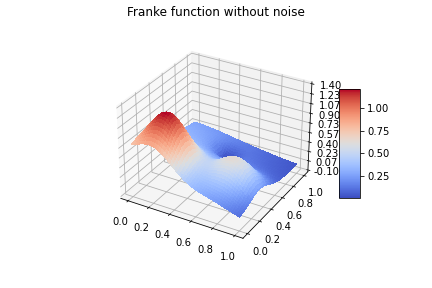

<IPython.core.display.Javascript object>


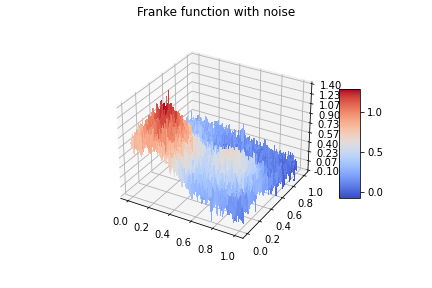

In [128]:
%matplotlib notebook

# Generate data without noise
x1, x2, y = create_data_franke.generate_data(noisy=False, points=100)

# Generate data with noise
_, _, y_noise = create_data_franke.generate_data(noisy=True, noise_variance=0.1, points=100)

# Plot data
create_plots.make_3d_surface_plot(x1, x2, y, title="Franke function without noise")
create_plots.make_3d_surface_plot(x1, x2, y_noise, title="Franke function with noise")

## Calculate Ordinary Least Squares for order 1
We want to find the best $\beta_{OLS}$ such that $\tilde{y}=D\beta_{OLS}$ where $D$ is the design matrix. $D$'s columns are different combination of the input variables $x_1$ and $x_2$. 
For example when we want to fit a plynomial with the order 2 to $y$ the design matrix has the columns: $1, x, y, xy, x^2, y^2$. The parameter $\beta_{OLS}$ is defined as: $$\beta_{OLS}:= (D^T D)^{-1}D^T y$$

[ 0.98860268 -0.66594379 -0.50052864]


<IPython.core.display.Javascript object>


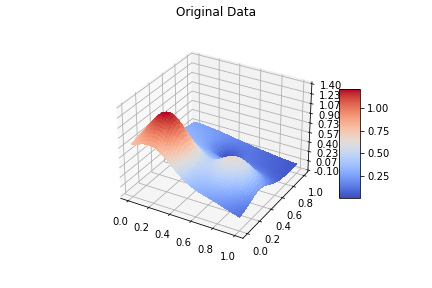

<IPython.core.display.Javascript object>


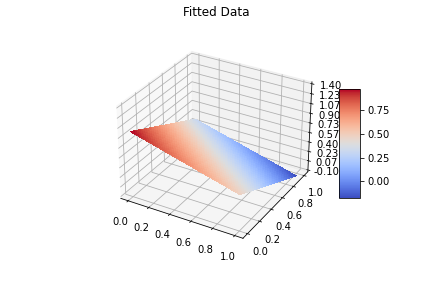

In [129]:
# Calculate beta and the response variable y_tilde for ordinary least squares.
beta_OLS, y_tilde_OLS = ordinary_least_squares.calculate_OLS(x1, x2, y, order=1)
print(beta_OLS)

# Plot y_tilde
create_plots.make_3d_surface_plot(x1, x2, y, title="Original Data")
create_plots.make_3d_surface_plot(x1, x2, y_tilde_OLS, title="Fitted Data")

## Perform OLS for several orders

noise=False, train_frac=0.8,cross_val=False, num_fold=0, bootstrap=False 

MSE train data: [[0.01533141 0.01100146 0.00525976 0.00255963 0.00143943]]
MSE test data: [[0.01738571 0.01369025 0.00535262 0.00363653 0.00126807]]
R2 train data: [[0.72179947 0.79417948 0.90670069 0.95020055 0.97418719]]
R2 test data: [[0.68955892 0.78543902 0.89671656 0.94494124 0.9765226 ]]


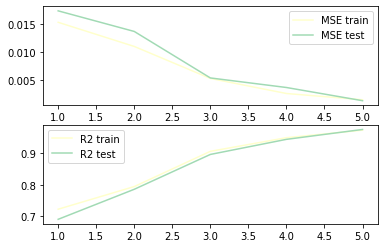

In [130]:
%matplotlib inline

# Fit model for different polynomial
max_order = 5
orders = range(1, max_order+1)
MSE_train = np.empty([1, max_order])
R2_train = np.empty([1, max_order])
MSE_test = np.empty([1, max_order])
R2_test = np.empty([1, max_order])

for i, order in enumerate(orders):
    _, _, _, MSE_train[:, i], MSE_test[:, i], R2_train[:, i], R2_test[:, i] = ordinary_least_squares.perform_OLS(x1, x2, y, order,
                                                                                                                 train_frac=0.8,
                                                                                                                 cross_val=False,
                                                                                                                 num_fold=0,
                                                                                                                 bootstrap=False)

# Plot errors
axes_1 = np.array(orders)
args = (MSE_train, MSE_test, R2_train, R2_test)
axes_2 = np.concatenate(args, axis=0)

line_lab = ['MSE train', 'MSE test', 'R2 train', 'R2 test']

fig_errors = plt.figure()
create_plots.make_multi_line_plot(axes_1, axes_2[:2, :], line_lab[:2], fig_errors, 211)
create_plots.make_multi_line_plot(axes_1, axes_2[2:, :], line_lab[2:], fig_errors, 212)

print("noise=False, train_frac=0.8,cross_val=False, num_fold=0, bootstrap=False \n")
print("MSE train data: " +  str(MSE_train))
print("MSE test data: " +  str(MSE_test))
print("R2 train data: " +  str(R2_train))
print("R2 test data: " +  str(R2_test))

## Multiple Orders

Start by defining a function which creates a heatmap from a pandas dataframe.

In [131]:
def create_heatmap(data, axis, title=None):
    """
    Creates a heatmap from a pandas dataframe.
    Inspired by: https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-heatmap-style/
    """
    # Reverse order of dataframe index
    data = data.sort_index(ascending=False)
    # Displaying dataframe as an heatmap
    sns.heatmap(data, linewidths = 0.30, annot = True, cmap="mako", ax=axis, vmin=0.001, vmax=0.02).set_title(title)

### Influence of the number of folds when using cross-validation

In [132]:
# Fit model for different polynomial orders and different amount of folds
max_order = 5
orders = range(1, max_order+1)

cross_val_folds = range(5, 11)

MSE_train = np.empty([len(cross_val_folds), max_order])
MSE_test = np.empty([len(cross_val_folds), max_order])


for folds_idx, n_folds in enumerate(cross_val_folds):
    for order_idx, order in enumerate(orders):
        _, _, _, MSE_train[folds_idx, order_idx], MSE_test[folds_idx, order_idx], _, _ = ordinary_least_squares.perform_OLS(x1, x2, y, order,
                                                                                                                            train_frac=0.8,
                                                                                                                            cross_val=True,
                                                                                                                            num_fold=n_folds,
                                                                                                                            bootstrap=False)
MSE_train_cross_df = pd.DataFrame(data=MSE_train, index=cross_val_folds, columns=orders)
MSE_test_cross_df = pd.DataFrame(data=MSE_test, index=cross_val_folds, columns=orders)

print("MSE training data:")
display(MSE_train_cross_df)
print("MSE test data:")
display(MSE_test_cross_df)

MSE training data:


,1,2,3,4,5
5,0.016921,0.011234,0.005402,0.002712,0.001372
6,0.016339,0.011411,0.005063,0.002798,0.001452
7,0.016681,0.011228,0.005030,0.002617,0.001439
8,0.016009,0.011191,0.005072,0.002646,0.001340
9,0.016854,0.011526,0.005189,0.002702,0.001395
10,0.016187,0.011275,0.005259,0.002718,0.001373


MSE test data:


,1,2,3,4,5
5,0.011635,0.013231,0.004678,0.003003,0.001591
6,0.012653,0.012130,0.006509,0.002503,0.001189
7,0.010292,0.013167,0.006698,0.003676,0.001221
8,0.014064,0.015123,0.006642,0.003587,0.001945
9,0.007066,0.011131,0.005796,0.003177,0.001499
10,0.011755,0.013509,0.005248,0.003037,0.001729


### Influence of train fraction

In [133]:
# Fit model for different polynomial orders and different train fractions, no boostrapping
max_order = 5
orders = range(1, max_order+1)

train_frac = np.round(np.arange(0.75, 1, 0.05),2)

MSE_train = np.empty([len(train_frac), max_order])
MSE_test = np.empty([len(train_frac), max_order])


for frac_idx, frac in enumerate(train_frac):
    for order_idx, order in enumerate(orders):
        _, _, _, MSE_train[frac_idx, order_idx], MSE_test[frac_idx, order_idx], _, _ = ordinary_least_squares.perform_OLS(x1, x2, y, order,
                                                                                                                            train_frac=frac,
                                                                                                                            cross_val=False,
                                                                                                                            num_fold=0,
                                                                                                                            bootstrap=False)
MSE_train_frac_df = pd.DataFrame(data=MSE_train, index=train_frac, columns=orders)
MSE_test_frac_df = pd.DataFrame(data=MSE_test, index=train_frac, columns=orders)

print("MSE training data:")
display(MSE_train_frac_df)
print("MSE test data:")
display(MSE_test_frac_df)

MSE training data:


,1,2,3,4,5
0.75,0.016336,0.011062,0.005753,0.002617,0.001401
0.80,0.015727,0.011132,0.005263,0.002819,0.001423
0.85,0.015531,0.011645,0.005050,0.002793,0.001478
0.90,0.015603,0.011506,0.005264,0.002722,0.001373
0.95,0.015895,0.011402,0.005165,0.002771,0.001416


MSE test data:


,1,2,3,4,5
0.75,0.014102,0.012924,0.003875,0.003228,0.001417
0.80,0.015989,0.012987,0.005263,0.002530,0.001339
0.85,0.016980,0.010991,0.006457,0.002532,0.000993
0.90,0.017848,0.011473,0.005164,0.003023,0.001693
0.95,0.013006,0.012994,0.006989,0.002311,0.001168


In [134]:
# Fit model for different polynomial orders and different train fractions, with boostrapping
max_order = 5
orders = range(1, max_order+1)

train_frac = np.round(np.arange(0.75, 1, 0.05),2)

MSE_train = np.empty([len(train_frac), max_order])
MSE_test = np.empty([len(train_frac), max_order])


for frac_idx, frac in enumerate(train_frac):
    for order_idx, order in enumerate(orders):
        _, _, _, MSE_train[frac_idx, order_idx], MSE_test[frac_idx, order_idx], _, _ = ordinary_least_squares.perform_OLS(x1, x2, y, order,
                                                                                                                            train_frac=frac,
                                                                                                                            cross_val=False,
                                                                                                                            num_fold=0,
                                                                                                                            bootstrap=True)
MSE_train_frac_boot_df = pd.DataFrame(data=MSE_train, index=train_frac, columns=orders)
MSE_test_frac_boot_df = pd.DataFrame(data=MSE_test, index=train_frac, columns=orders)

print("MSE training data:")
display(MSE_train_frac_boot_df)
print("MSE test data:")
display(MSE_test_frac_boot_df)

MSE training data:


,1,2,3,4,5
0.75,0.013313,0.011509,0.004677,0.002747,0.001332
0.80,0.015212,0.011154,0.005203,0.002653,0.001439
0.85,0.014707,0.010641,0.004990,0.002785,0.001376
0.90,0.015410,0.011301,0.005238,0.002631,0.001382
0.95,0.015036,0.011476,0.005377,0.002746,0.001421


MSE test data:


,1,2,3,4,5
0.75,0.023209,0.013083,0.007179,0.002828,0.001453
0.80,0.016496,0.012696,0.005414,0.003514,0.001284
0.85,0.019833,0.015779,0.005615,0.002796,0.001336
0.90,0.015045,0.012563,0.005768,0.003292,0.001439
0.95,0.014717,0.012106,0.005709,0.003068,0.000662


Make comparison between different sampling methods

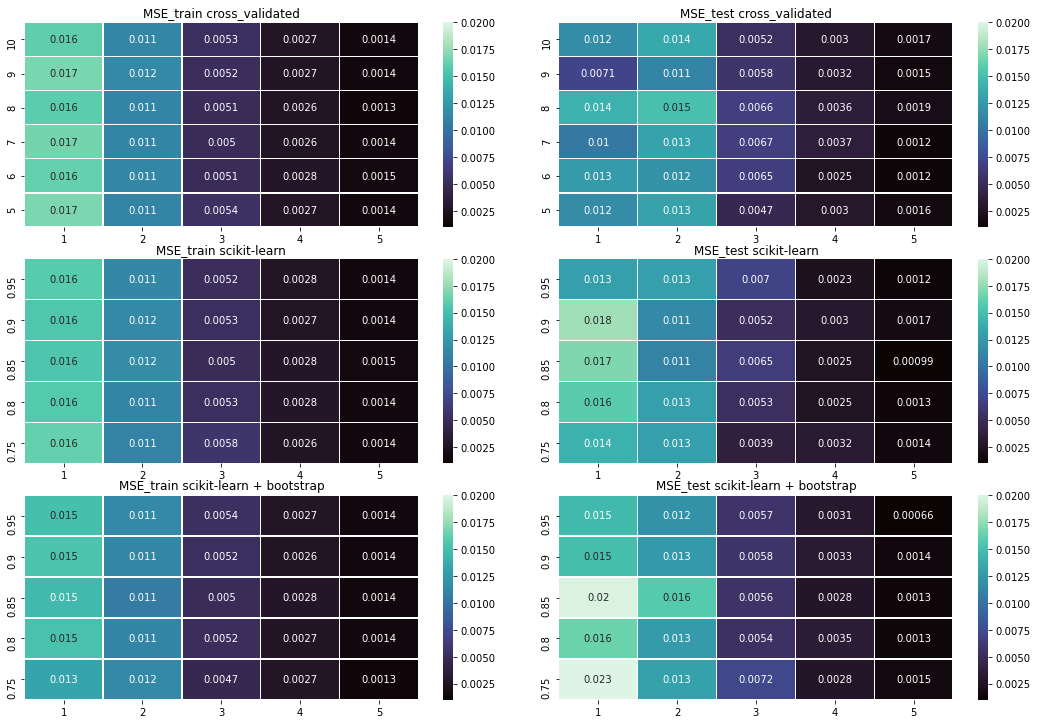

In [135]:
%matplotlib inline

fig, ax = plt.subplots(3,2,figsize=(15,10))
fig.tight_layout()

# Cross-validated data
create_heatmap(MSE_train_cross_df, title="MSE_train cross_validated", axis=ax[0][0])
create_heatmap(MSE_test_cross_df, title="MSE_test cross_validated", axis=ax[0][1])

# Sklearn splitting in train9ing and testing data (without bootstrap)
create_heatmap(MSE_train_frac_df, title="MSE_train scikit-learn", axis=ax[1][0])
create_heatmap(MSE_test_frac_df, title="MSE_test scikit-learn", axis=ax[1][1])

# Sklearn splitting in train9ing and testing data (without bootstrap)
create_heatmap(MSE_train_frac_boot_df, title="MSE_train scikit-learn + bootstrap", axis=ax[2][0])
create_heatmap(MSE_test_frac_boot_df, title="MSE_test scikit-learn + bootstrap", axis=ax[2][1])